In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
from preprocessing import *
from save_and_compare_results import *
from sklearn.linear_model import LassoCV
import shap

In [2]:
# Load the preprocessed data
X = pd.read_pickle("X_matrix_proteins.pkl")
Y = pd.read_pickle("Y_matrix_proteins.pkl")

In [3]:
# Preprocess the data
X = X.drop(columns=["Yeast_ID"]).fillna(0)
Y = Y.drop(columns=["Yeast_ID"]).fillna(Y.drop(columns=["Yeast_ID"]).mean())

In [4]:
# Define the hyperparameter grid
GBM_distributions = dict(
    max_features=["auto", "log2", "sqrt"],
    learning_rate=uniform(1e-3, 1),
    subsample=uniform(0, 1),
    min_samples_split=randint(2, 100),
    min_samples_leaf=randint(2, 100),
    n_estimators=randint(10, 200),
    criterion=['friedman_mse', 'squared_error'],
    max_depth=randint(2, 10)
)

In [18]:
n_iterations = 100
cross_val = 3
random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=GBM_distributions,
    n_iter=n_iterations,
    verbose=2,
    cv=cross_val,
    n_jobs=-1,
    random_state=42
)

# Fit the model
print("Running hyperparameter tuning for Gradient Boosting...")
random_search.fit(X, Y)

Running hyperparameter tuning for Gradient Boosting...
Fitting 3 folds for each of 100 candidates, totalling 300 fits


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=friedman_mse, learning_rate=0.7975429868602328, max_depth=8, max_features=sqrt, min_samples_leaf=73, min_samples_split=62, n_estimators=30, subsample=0.15601864044243652; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.7975429868602328, max_depth=8, max_features=sqrt, min_samples_leaf=73, min_samples_split=62, n_estimators=30, subsample=0.15601864044243652; total time=   0.5s
[CV] END criterion=friedman_mse, learning_rate=0.10097491581800289, max_depth=4, max_features=auto, min_samples_leaf=25, min_samples_split=4, n_estimators=159, subsample=0.056411579027100256; total time=   0.5s
[CV] END criterion=friedman_mse, learning_rate=0.7975429868602328, max_depth=8, max_features=sqrt, min_samples_leaf=73, min_samples_split=62, n_estimators=30, subsample=0.15601864044243652; total time=   0.5s
[CV] END criterion=friedman_mse, learning_rate=0.10097491581800289, max_depth=4, max_features=auto, min_samples_leaf=25, min_samples_split=4, n_estimators=159, su

/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=squared_error, learning_rate=0.8334426408004217, max_depth=7, max_features=log2, min_samples_leaf=65, min_samples_split=61, n_estimators=30, subsample=0.6174815096277165; total time=   0.5s
[CV] END criterion=friedman_mse, learning_rate=0.10097491581800289, max_depth=4, max_features=auto, min_samples_leaf=25, min_samples_split=4, n_estimators=159, subsample=0.056411579027100256; total time=   0.5s
[CV] END criterion=squared_error, learning_rate=0.8334426408004217, max_depth=7, max_features=log2, min_samples_leaf=65, min_samples_split=61, n_estimators=30, subsample=0.6174815096277165; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.8334426408004217, max_depth=7, max_features=log2, min_samples_leaf=65, min_samples_split=61, n_estimators=30, subsample=0.6174815096277165; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.29314464853521816, max_depth=9, max_features=sqrt, min_samples_leaf=63, min_samples_split=63, n_estimators=184, subsample=0.6183860093330873; total time=   0.6s
[CV] END criterion=squared_error, learning_rate=0.29314464853521816, max_depth=9, max_features=sqrt, min_samples_leaf=63, min_samples_split=63, n_estimators=184, subsample=0.6183860093330873; total time=   0.6s
[CV] END criterion=squared_error, learning_rate=0.29314464853521816, max_depth=9, max_features=sqrt, min_samples_leaf=63, min_samples_split=63, n_estimators=184, subsample=0.6183860093330873; total time=   0.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=friedman_mse, learning_rate=0.01426496115986653, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=91, n_estimators=62, subsample=0.230893825622149; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.01426496115986653, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=91, n_estimators=62, subsample=0.230893825622149; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.01426496115986653, max_depth=2, max_features=log2, min_samples_leaf=10, min_samples_split=91, n_estimators=62, subsample=0.230893825622149; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5257564316322378, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=92, n_estimators=68, subsample=0.3998609717152555; total time=   3.6s
[CV] END criterion=squared_error, learning_rate=0.5257564316322378, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=92, n_estimators=68, subsample=0.3998609717152555; total time=   3.9s
[CV] END criterion=squared_error, learning_rate=0.5257564316322378, max_depth=5, max_features=auto, min_samples_leaf=50, min_samples_split=92, n_estimators=68, subsample=0.3998609717152555; total time=   4.0s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.18323608778806233, max_depth=5, max_features=log2, min_samples_leaf=7, min_samples_split=55, n_estimators=115, subsample=0.5677003278199915; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.18323608778806233, max_depth=5, max_features=log2, min_samples_leaf=7, min_samples_split=55, n_estimators=115, subsample=0.5677003278199915; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.9705846277645586, max_depth=3, max_features=log2, min_samples_leaf=75, min_samples_split=63, n_estimators=23, subsample=0.7272719958564209; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.18323608778806233, max_depth=5, max_features=log2, min_samples_leaf=7, min_samples_split=55, n_estimators=115, subsample=0.5677003278199915; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.9705846277645586, max_depth=3, max_features=log2, min_samples_leaf=75, min_samples_split=63, n_estimators=23, subsample=0.7272719958564209; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.9705846277645586, max_depth=3, max_features=log2, min_samples_leaf=75, min_samples_split=63, n_estimators=23, subsample=0.7272719958564209; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5152344384136116, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=52, n_estimators=144, subsample=0.17052412368729153; total time=   7.2s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5152344384136116, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=52, n_estimators=144, subsample=0.17052412368729153; total time=   7.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5152344384136116, max_depth=9, max_features=auto, min_samples_leaf=4, min_samples_split=52, n_estimators=144, subsample=0.17052412368729153; total time=   7.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3577533266935893, max_depth=5, max_features=auto, min_samples_leaf=42, min_samples_split=30, n_estimators=24, subsample=0.1652669390630025; total time=   0.8s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3577533266935893, max_depth=5, max_features=auto, min_samples_leaf=42, min_samples_split=30, n_estimators=24, subsample=0.1652669390630025; total time=   1.0s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3577533266935893, max_depth=5, max_features=auto, min_samples_leaf=42, min_samples_split=30, n_estimators=24, subsample=0.1652669390630025; total time=   0.8s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.0894925020519195, max_depth=8, max_features=auto, min_samples_leaf=63, min_samples_split=41, n_estimators=91, subsample=0.5396921323890798; total time=   7.6s
[CV] END criterion=friedman_mse, learning_rate=0.0894925020519195, max_depth=8, max_features=auto, min_samples_leaf=63, min_samples_split=41, n_estimators=91, subsample=0.5396921323890798; total time=   7.9s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.0894925020519195, max_depth=8, max_features=auto, min_samples_leaf=63, min_samples_split=41, n_estimators=91, subsample=0.5396921323890798; total time=   8.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.4411524937396013, max_depth=8, max_features=auto, min_samples_leaf=9, min_samples_split=48, n_estimators=44, subsample=0.9093204020787821; total time=  19.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.4411524937396013, max_depth=8, max_features=auto, min_samples_leaf=9, min_samples_split=48, n_estimators=44, subsample=0.9093204020787821; total time=  20.1s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.4504506741382034, max_depth=2, max_features=sqrt, min_samples_leaf=24, min_samples_split=63, n_estimators=46, subsample=0.7296061783380641; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.71234195274865, max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=42, n_estimators=37, subsample=0.8631034258755935; total time=  10.1s
[CV] END criterion=squared_error, learning_rate=0.4504506741382034, max_depth=2, max_features=sqrt, min_samples_leaf=24, min_samples_split=63, n_estimators=46, subsample=0.7296061783380641; total time=   0.9s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.4504506741382034, max_depth=2, max_features=sqrt, min_samples_leaf=24, min_samples_split=63, n_estimators=46, subsample=0.7296061783380641; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.4411524937396013, max_depth=8, max_features=auto, min_samples_leaf=9, min_samples_split=48, n_estimators=44, subsample=0.9093204020787821; total time=  20.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.71234195274865, max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=42, n_estimators=37, subsample=0.8631034258755935; total time=   8.9s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.23698491974895575, max_depth=7, max_features=sqrt, min_samples_leaf=28, min_samples_split=10, n_estimators=24, subsample=0.11089082081183133; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.23698491974895575, max_depth=7, max_features=sqrt, min_samples_leaf=28, min_samples_split=10, n_estimators=24, subsample=0.11089082081183133; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.23698491974895575, max_depth=7, max_features=sqrt, min_samples_leaf=28, min_samples_split=10, n_estimators=24, subsample=0.11089082081183133; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.10889142699330445, max_depth=8, max_features=sqrt, min_samples_leaf=53, min_samples_split=97, n_estimators=141, subsample=0.907566473926093; total time=   0.7s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.10889142699330445, max_depth=8, max_features=sqrt, min_samples_leaf=53, min_samples_split=97, n_estimators=141, subsample=0.907566473926093; total time=   0.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.10889142699330445, max_depth=8, max_features=sqrt, min_samples_leaf=53, min_samples_split=97, n_estimators=141, subsample=0.907566473926093; total time=   0.7s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.6054173792778172, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=37, n_estimators=22, subsample=0.07697990982879299; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.6054173792778172, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=37, n_estimators=22, subsample=0.07697990982879299; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.6054173792778172, max_depth=8, max_features=sqrt, min_samples_leaf=30, min_samples_split=37, n_estimators=22, subsample=0.07697990982879299; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.6957849330397046, max_depth=5, max_features=log2, min_samples_leaf=43, min_samples_split=46, n_estimators=71, subsample=0.6334037565104235; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.71234195274865, max_depth=4, max_features=auto, min_samples_leaf=6, min_samples_split=42, n_estimators=37, subsample=0.8631034258755935; total time=   9.2s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.6957849330397046, max_depth=5, max_features=log2, min_samples_leaf=43, min_samples_split=46, n_estimators=71, subsample=0.6334037565104235; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.6957849330397046, max_depth=5, max_features=log2, min_samples_leaf=43, min_samples_split=46, n_estimators=71, subsample=0.6334037565104235; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.45753457048291024, max_depth=5, max_features=log2, min_samples_leaf=63, min_samples_split=76, n_estimators=137, subsample=0.8074401551640625; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.45753457048291024, max_depth=5, max_features=log2, min_samples_leaf=63, min_samples_split=76, n_estimators=137, subsample=0.8074401551640625; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.45753457048291024, max_depth=5, max_features=log2, min_samples_leaf=63, min_samples_split=76, n_estimators=137, subsample=0.8074401551640625; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3572978380769749, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=28, n_estimators=199, subsample=0.0005203769953158188; total time=   0.5s
[CV] END criterion=squared_error, learning_rate=0.3572978380769749, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=28, n_estimators=199, subsample=0.0005203769953158188; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3572978380769749, max_depth=7, max_features=auto, min_samples_leaf=2, min_samples_split=28, n_estimators=199, subsample=0.0005203769953158188; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.8617305832563434, max_depth=8, max_features=log2, min_samples_leaf=73, min_samples_split=28, n_estimators=146, subsample=0.4848299713589832; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.8617305832563434, max_depth=8, max_features=log2, min_samples_leaf=73, min_samples_split=28, n_estimators=146, subsample=0.4848299713589832; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.8617305832563434, max_depth=8, max_features=log2, min_samples_leaf=73, min_samples_split=28, n_estimators=146, subsample=0.4848299713589832; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.1208653673336828, max_depth=5, max_features=sqrt, min_samples_leaf=60, min_samples_split=33, n_estimators=105, subsample=0.5581020020173412; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.1208653673336828, max_depth=5, max_features=sqrt, min_samples_leaf=60, min_samples_split=33, n_estimators=105, subsample=0.5581020020173412; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.364629602379294, max_depth=2, max_features=log2, min_samples_leaf=53, min_samples_split=13, n_estimators=48, subsample=0.49724850589238545; total time=   0.5s
[CV] END criterion=friedman_mse, learning_rate=0.1208653673336828, max_depth=5, max_features=sqrt, min_samples_leaf=60, min_samples_split=33, n_estimators=105, subsample=0.5581020020173412; total time=   0.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.364629602379294, max_depth=2, max_features=log2, min_samples_leaf=53, min_samples_split=13, n_estimators=48, subsample=0.49724850589238545; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.364629602379294, max_depth=2, max_features=log2, min_samples_leaf=53, min_samples_split=13, n_estimators=48, subsample=0.49724850589238545; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.9878869366005173, max_depth=9, max_features=auto, min_samples_leaf=9, min_samples_split=89, n_estimators=72, subsample=0.8154614284548342; total time=  24.7s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.9878869366005173, max_depth=9, max_features=auto, min_samples_leaf=9, min_samples_split=89, n_estimators=72, subsample=0.8154614284548342; total time=  25.2s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.9878869366005173, max_depth=9, max_features=auto, min_samples_leaf=9, min_samples_split=89, n_estimators=72, subsample=0.8154614284548342; total time=  22.9s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.27964646423661144, max_depth=2, max_features=auto, min_samples_leaf=20, min_samples_split=3, n_estimators=62, subsample=0.489452760277563; total time=   4.8s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.27964646423661144, max_depth=2, max_features=auto, min_samples_leaf=20, min_samples_split=3, n_estimators=62, subsample=0.489452760277563; total time=   4.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.1490869299533999, max_depth=9, max_features=auto, min_samples_leaf=60, min_samples_split=3, n_estimators=139, subsample=0.4110370133182313; total time=   6.6s
[CV] END criterion=squared_error, learning_rate=0.553893089071328, max_depth=8, max_features=sqrt, min_samples_leaf=76, min_samples_split=57, n_estimators=132, subsample=0.24215993827742588; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.1490869299533999, max_depth=9, max_features=auto, min_samples_leaf=60, min_samples_split=3, n_estimators=139, subsample=0.4110370133182313; total time=   6.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.1490869299533999, max_depth=9, max_features=auto, min_samples_leaf=60, min_samples_split=3, n_estimators=139, subsample=0.4110370133182313; total time=   6.8s
[CV] END criterion=squared_error, learning_rate=0.553893089071328, max_depth=8, max_features=sqrt, min_samples_leaf=76, min_samples_split=57, n_estimators=132, subsample=0.24215993827742588; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.553893089071328, max_depth=8, max_features=sqrt, min_samples_leaf=76, min_samples_split=57, n_estimators=132, subsample=0.24215993827742588; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.3687831327192532, max_depth=5, max_features=log2, min_samples_leaf=71, min_samples_split=87, n_estimators=148, subsample=0.8164318732193839; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=squared_error, learning_rate=0.3687831327192532, max_depth=5, max_features=log2, min_samples_leaf=71, min_samples_split=87, n_estimators=148, subsample=0.8164318732193839; total time=   0.5s
[CV] END criterion=squared_error, learning_rate=0.3687831327192532, max_depth=5, max_features=log2, min_samples_leaf=71, min_samples_split=87, n_estimators=148, subsample=0.8164318732193839; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.836302495589238, max_depth=5, max_features=sqrt, min_samples_leaf=71, min_samples_split=81, n_estimators=102, subsample=0.8583588048137198; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.836302495589238, max_depth=5, max_features=sqrt, min_samples_leaf=71, min_samples_split=81, n_estimators=102, subsample=0.8583588048137198; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.836302495589238, max_depth=5, max_features=sqrt, min_samples_leaf=71, min_samples_split=81, n_estimators=102, subsample=0.8583588048137198; total time=   0.5s
[CV] END criterion=squared_error, learning_rate=0.6785643618422824, max_depth=4, max_features=log2, min_samples_leaf=68, min_samples_split=20, n_estimators=157, subsample=0.6451727904094499; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.6785643618422824, max_depth=4, max_features=log2, min_samples_leaf=68, min_samples_split=20, n_estimators=157, subsample=0.6451727904094499; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.6785643618422824, max_depth=4, max_features=log2, min_samples_leaf=68, min_samples_split=20, n_estimators=157, subsample=0.6451727904094499; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=squared_error, learning_rate=0.941523264489604, max_depth=9, max_features=sqrt, min_samples_leaf=83, min_samples_split=2, n_estimators=20, subsample=0.3410663510502585; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.941523264489604, max_depth=9, max_features=sqrt, min_samples_leaf=83, min_samples_split=2, n_estimators=20, subsample=0.3410663510502585; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.941523264489604, max_depth=9, max_features=sqrt, min_samples_leaf=83, min_samples_split=2, n_estimators=20, subsample=0.3410663510502585; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.21007162073771368, max_depth=8, max_features=log2, min_samples_leaf=43, min_samples_split=8, n_estimators=153, subsample=0.8172222002012158; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.21007162073771368, max_depth=8, max_features=log2, min_samples_leaf=43, min_samples_split=8, n_estimators=153, subsample=0.8172222002012158; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.21007162073771368, max_depth=8, max_features=log2, min_samples_leaf=43, min_samples_split=8, n_estimators=153, subsample=0.8172222002012158; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.5176358912710143, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=49, n_estimators=149, subsample=0.5582934536070976; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.5176358912710143, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=49, n_estimators=149, subsample=0.5582934536070976; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.5176358912710143, max_depth=2, max_features=log2, min_samples_leaf=2, min_samples_split=49, n_estimators=149, subsample=0.5582934536070976; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.7808755458576239, max_depth=9, max_features=sqrt, min_samples_leaf=73, min_samples_split=37, n_estimators=175, subsample=0.6689882547142286; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.7808755458576239, max_depth=9, max_features=sqrt, min_samples_leaf=73, min_samples_split=37, n_estimators=175, subsample=0.6689882547142286; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.27964646423661144, max_depth=2, max_features=auto, min_samples_leaf=20, min_samples_split=3, n_estimators=62, subsample=0.489452760277563; total time=   4.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.7808755458576239, max_depth=9, max_features=sqrt, min_samples_leaf=73, min_samples_split=37, n_estimators=175, subsample=0.6689882547142286; total time=   0.5s
[CV] END criterion=squared_error, learning_rate=0.010197051616629649, max_depth=7, max_features=auto, min_samples_leaf=26, min_samples_split=94, n_estimators=155, subsample=0.16080805141749865; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.010197051616629649, max_depth=7, max_features=auto, min_samples_leaf=26, min_samples_split=94, n_estimators=155, subsample=0.16080805141749865; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.010197051616629649, max_depth=7, max_features=auto, min_samples_leaf=26, min_samples_split=94, n_estimators=155, subsample=0.16080805141749865; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.27572179299006416, max_depth=4, max_features=auto, min_samples_leaf=48, min_samples_split=79, n_estimators=140, subsample=0.7607850486168974; total time=  22.2s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.27572179299006416, max_depth=4, max_features=auto, min_samples_leaf=48, min_samples_split=79, n_estimators=140, subsample=0.7607850486168974; total time=  22.4s
[CV] END criterion=squared_error, learning_rate=0.27572179299006416, max_depth=4, max_features=auto, min_samples_leaf=48, min_samples_split=79, n_estimators=140, subsample=0.7607850486168974; total time=  21.8s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.1798227092213288, max_depth=9, max_features=sqrt, min_samples_leaf=68, min_samples_split=18, n_estimators=137, subsample=0.5683086033354716; total time=   0.6s
[CV] END criterion=friedman_mse, learning_rate=0.1798227092213288, max_depth=9, max_features=sqrt, min_samples_leaf=68, min_samples_split=18, n_estimators=137, subsample=0.5683086033354716; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.4866137535862266, max_depth=4, max_features=auto, min_samples_leaf=42, min_samples_split=34, n_estimators=77, subsample=0.23724908749680007; total time=   1.7s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.4866137535862266, max_depth=4, max_features=auto, min_samples_leaf=42, min_samples_split=34, n_estimators=77, subsample=0.23724908749680007; total time=   1.8s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.1798227092213288, max_depth=9, max_features=sqrt, min_samples_leaf=68, min_samples_split=18, n_estimators=137, subsample=0.5683086033354716; total time=   0.5s
[CV] END criterion=squared_error, learning_rate=0.50981407683876, max_depth=7, max_features=sqrt, min_samples_leaf=23, min_samples_split=31, n_estimators=47, subsample=0.978892858275009; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.50981407683876, max_depth=7, max_features=sqrt, min_samples_leaf=23, min_samples_split=31, n_estimators=47, subsample=0.978892858275009; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.4866137535862266, max_depth=4, max_features=auto, min_samples_leaf=42, min_samples_split=34, n_estimators=77, subsample=0.23724908749680007; total time=   1.8s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=squared_error, learning_rate=0.50981407683876, max_depth=7, max_features=sqrt, min_samples_leaf=23, min_samples_split=31, n_estimators=47, subsample=0.978892858275009; total time=   0.5s
[CV] END criterion=friedman_mse, learning_rate=0.8930465551771133, max_depth=4, max_features=sqrt, min_samples_leaf=99, min_samples_split=22, n_estimators=39, subsample=0.6451033620305648; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.8930465551771133, max_depth=4, max_features=sqrt, min_samples_leaf=99, min_samples_split=22, n_estimators=39, subsample=0.6451033620305648; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.8930465551771133, max_depth=4, max_features=sqrt, min_samples_leaf=99, min_samples_split=22, n_estimators=39, subsample=0.6451033620305648; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.4935176938188639, max_depth=6, max_features=auto, min_samples_leaf=49, min_samples_split=20, n_estimators=13, subsample=0

/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=friedman_mse, learning_rate=0.4935176938188639, max_depth=6, max_features=auto, min_samples_leaf=49, min_samples_split=20, n_estimators=13, subsample=0.02431596643145384; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.4935176938188639, max_depth=6, max_features=auto, min_samples_leaf=49, min_samples_split=20, n_estimators=13, subsample=0.02431596643145384; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.04460377175443375, max_depth=5, max_features=log2, min_samples_leaf=94, min_samples_split=47, n_estimators=126, subsample=0.883494022266259; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.04460377175443375, max_depth=5, max_features=log2, min_samples_leaf=94, min_samples_split=47, n_estimators=126, subsample=0.883494022266259; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.04460377175443375, max_depth=5, max_features=log2, min_samples_leaf=94, min_samples_split=47, n_estimators=126, subsample=0.883494022266259; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.07634625600612821, max_depth=6, max_features=auto, min_samples_leaf=33, min_samples_split=88, n_estimators=170, subsample=0.31692200515627766; total time=   7.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.07634625600612821, max_depth=6, max_features=auto, min_samples_leaf=33, min_samples_split=88, n_estimators=170, subsample=0.31692200515627766; total time=   7.8s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3736868670940493, max_depth=3, max_features=sqrt, min_samples_leaf=55, min_samples_split=59, n_estimators=76, subsample=0.570061170089365; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3736868670940493, max_depth=3, max_features=sqrt, min_samples_leaf=55, min_samples_split=59, n_estimators=76, subsample=0.570061170089365; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3736868670940493, max_depth=3, max_features=sqrt, min_samples_leaf=55, min_samples_split=59, n_estimators=76, subsample=0.570061170089365; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.6341014572732679, max_depth=2, max_features=auto, min_samples_leaf=20, min_samples_split=49, n_estimators=140, subsample=0.8563242918780924; total time=  14.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.6341014572732679, max_depth=2, max_features=auto, min_samples_leaf=20, min_samples_split=49, n_estimators=140, subsample=0.8563242918780924; total time=  14.7s
[CV] END criterion=squared_error, learning_rate=0.20991871761536018, max_depth=8, max_features=log2, min_samples_leaf=24, min_samples_split=67, n_estimators=136, subsample=0.5183296523637367; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.6341014572732679, max_depth=2, max_features=auto, min_samples_leaf=20, min_samples_split=49, n_estimators=140, subsample=0.8563242918780924; total time=  14.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.20991871761536018, max_depth=8, max_features=log2, min_samples_leaf=24, min_samples_split=67, n_estimators=136, subsample=0.5183296523637367; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.20991871761536018, max_depth=8, max_features=log2, min_samples_leaf=24, min_samples_split=67, n_estimators=136, subsample=0.5183296523637367; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.8103611554785136, max_depth=4, max_features=log2, min_samples_leaf=26, min_samples_split=25, n_estimators=22, subsample=0.08159418040024036; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.8103611554785136, max_depth=4, max_features=log2, min_samples_leaf=26, min_samples_split=25, n_estimators=22, subsample=0.08159418040024036; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.8103611554785136, max_depth=4, max_features=log2, min_samples_leaf=26, min_samples_split=25, n_estimators=22, subsample=0.08159418040024036; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.07634625600612821, max_depth=6, max_features=auto, min_samples_leaf=33, min_samples_split=88, n_estimators=170, subsample=0.31692200515627766; total time=   7.2s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.01645661652886743, max_depth=9, max_features=auto, min_samples_leaf=47, min_samples_split=54, n_estimators=104, subsample=0.9636199770892528; total time=  22.8s
[CV] END criterion=squared_error, learning_rate=0.01645661652886743, max_depth=9, max_features=auto, min_samples_leaf=47, min_samples_split=54, n_estimators=104, subsample=0.9636199770892528; total time=  22.9s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.028616771873704705, max_depth=3, max_features=log2, min_samples_leaf=33, min_samples_split=88, n_estimators=95, subsample=0.32815266747473193; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.028616771873704705, max_depth=3, max_features=log2, min_samples_leaf=33, min_samples_split=88, n_estimators=95, subsample=0.32815266747473193; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.028616771873704705, max_depth=3, max_features=log2, min_samples_leaf=33, min_samples_split=88, n_estimators=95, subsample=0.32815266747473193; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5436446347075766, max_depth=6, max_features=log2, min_samples_leaf=59, min_samples_split=59, n_estimators=95, subsample=0.25025136051586405; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.01645661652886743, max_depth=9, max_features=auto, min_samples_leaf=47, min_samples_split=54, n_estimators=104, subsample=0.9636199770892528; total time=  24.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5436446347075766, max_depth=6, max_features=log2, min_samples_leaf=59, min_samples_split=59, n_estimators=95, subsample=0.25025136051586405; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.5436446347075766, max_depth=6, max_features=log2, min_samples_leaf=59, min_samples_split=59, n_estimators=95, subsample=0.25025136051586405; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.8236005606596583, max_depth=7, max_features=sqrt, min_samples_leaf=61, min_samples_split=98, n_estimators=17, subsample=0.7699935530986108; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.8236005606596583, max_depth=7, max_features=sqrt, min_samples_leaf=61, min_samples_split=98, n_estimators=17, subsample=0.7699935530986108; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.8236005606596583, max_depth=7, max_features=sqrt, min_samples_leaf=61, min_samples_split=98, n_estimators=17, subsample=0.7699935530986108; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.9662518303907698, max_depth=8, max_features=log2, min_samples_leaf=97, min_samples_split=95, n_estimators=56, subsample=0.6995122107671938; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.9662518303907698, max_depth=8, max_features=log2, min_samples_leaf=97, min_samples_split=95, n_estimators=56, subsample=0.6995122107671938; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.9662518303907698, max_depth=8, max_features=log2, min_samples_leaf=97, min_samples_split=95, n_estimators=56, subsample=0.6995122107671938; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.7270913337226615, max_depth=6, max_features=log2, min_samples_leaf=31, min_samples_split=20, n_estimators=154, subsample=0.39882090144479454; total time=   0.5s
[CV] END criterion=squared_error, learning_rate=0.7270913337226615, max_depth=6, max_features=log2, min_samples_leaf=31, min_samples_split=20, n_estimators=154, subsample=0.39882090144479454; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.4399714207056361, max_depth=8, max_features=log2, min_samples_leaf=91, min_samples_split=63, n_estimators=32, subsample=0.42831447494010777; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.7270913337226615, max_depth=6, max_features=log2, min_samples_leaf=31, min_samples_split=20, n_estimators=154, subsample=0.39882090144479454; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.4399714207056361, max_depth=8, max_features=log2, min_samples_leaf=91, min_samples_split=63, n_estimators=32, subsample=0.42831447494010777; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.4399714207056361, max_depth=8, max_features=log2, min_samples_leaf=91, min_samples_split=63, n_estimators=32, subsample=0.42831447494010777; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.4099529444142699, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=35, n_estimators=105, subsample=0.5492266647061205; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.4099529444142699, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=35, n_estimators=105, subsample=0.5492266647061205; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.4099529444142699, max_depth=3, max_features=log2, min_samples_leaf=2, min_samples_split=35, n_estimators=105, subsample=0.5492266647061205; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3235507642386005, max_depth=9, max_features=auto, min_samples_leaf=10, min_samples_split=44, n_estimators=185, subsample=0.5528199769079077; total time=  44.7s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3235507642386005, max_depth=9, max_features=auto, min_samples_leaf=10, min_samples_split=44, n_estimators=185, subsample=0.5528199769079077; total time=  45.8s
[CV] END criterion=squared_error, learning_rate=0.3235507642386005, max_depth=9, max_features=auto, min_samples_leaf=10, min_samples_split=44, n_estimators=185, subsample=0.5528199769079077; total time=  46.2s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.43667289867789105, max_depth=6, max_features=sqrt, min_samples_leaf=68, min_samples_split=77, n_estimators=163, subsample=0.3559726786512616; total time=   0.5s
[CV] END criterion=friedman_mse, learning_rate=0.43667289867789105, max_depth=6, max_features=sqrt, min_samples_leaf=68, min_samples_split=77, n_estimators=163, subsample=0.3559726786512616; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.12116464780564218, max_depth=6, max_features=log2, min_samples_leaf=93, min_samples_split=70, n_estimators=56, subsample=0.040728802318970136; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.43667289867789105, max_depth=6, max_features=sqrt, min_samples_leaf=68, min_samples_split=77, n_estimators=163, subsample=0.3559726786512616; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.12116464780564218, max_depth=6, max_features=log2, min_samples_leaf=93, min_samples_split=70, n_estimators=56, subsample=0.040728802318970136; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.12116464780564218, max_depth=6, max_features=log2, min_samples_leaf=93, min_samples_split=70, n_estimators=56, subsample=0.040728802318970136; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.9805105286215086, max_depth=6, max_features=log2, min_samples_leaf=91, min_samples_split=49, n_estimators=94, subsample=0.4734717707805657; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.9805105286215086, max_depth=6, max_features=log2, min_samples_leaf=91, min_samples_split=49, n_estimators=94, subsample=0.4734717707805657; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.4656738129396114, max_depth=6, max_features=sqrt, min_samples_leaf=11, min_samples_split=70, n_estimators=109, subsample=0.04530400977204452; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.9805105286215086, max_depth=6, max_features=log2, min_samples_leaf=91, min_samples_split=49, n_estimators=94, subsample=0.4734717707805657; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.4656738129396114, max_depth=6, max_features=sqrt, min_samples_leaf=11, min_samples_split=70, n_estimators=109, subsample=0.04530400977204452; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.4656738129396114, max_depth=6, max_features=sqrt, min_samples_leaf=11, min_samples_split=70, n_estimators=109, subsample=0.04530400977204452; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.01630454029038475, max_depth=4, max_features=log2, min_samples_leaf=97, min_samples_split=2, n_estimators=78, subsample=0.6839637693981411; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.01630454029038475, max_depth=4, max_features=log2, min_samples_leaf=97, min_samples_split=2, n_estimators=78, subsample=0.6839637693981411; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.01630454029038475, max_depth=4, max_features=log2, min_samples_leaf=97, min_samples_split=2, n_estimators=78, subsample=0.6839637693981411; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.07156874740042984, max_depth=8, max_features=log2, min_samples_leaf=93, min_samples_split=33, n_estimators=93, subsample=0.575474177875879; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.07156874740042984, max_depth=8, max_features=log2, min_samples_leaf=93, min_samples_split=33, n_estimators=93, subsample=0.575474177875879; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.07156874740042984, max_depth=8, max_features=log2, min_samples_leaf=93, min_samples_split=33, n_estimators=93, subsample=0.575474177875879; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.5025162946871996, max_depth=6, max_features=auto, min_samples_leaf=9, min_samples_split=17, n_estimators=151, subsample=0.8900053418175663; total time=  50.9s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.5025162946871996, max_depth=6, max_features=auto, min_samples_leaf=9, min_samples_split=17, n_estimators=151, subsample=0.8900053418175663; total time=  49.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.8214268437712681, max_depth=9, max_features=log2, min_samples_leaf=44, min_samples_split=45, n_estimators=38, subsample=0.06936130087516545; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.8214268437712681, max_depth=9, max_features=log2, min_samples_leaf=44, min_samples_split=45, n_estimators=38, subsample=0.06936130087516545; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.8214268437712681, max_depth=9, max_features=log2, min_samples_leaf=44, min_samples_split=45, n_estimators=38, subsample=0.06936130087516545; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.37825908322797586, max_depth=6, max_features=sqrt, min_samples_leaf=36, min_samples_split=88, n_estimators=90, subsample=0.6557226353807422; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.37825908322797586, max_depth=6, max_features=sqrt, min_samples_leaf=36, min_samples_split=88, n_estimators=90, subsample=0.6557226353807422; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.37825908322797586, max_depth=6, max_features=sqrt, min_samples_leaf=36, min_samples_split=88, n_estimators=90, subsample=0.6557226353807422; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.8458753109694546, max_depth=3, max_features=log2, min_samples_leaf=35, min_samples_split=8, n_estimators=67, subsample=0.6967371653641506; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.8458753109694546, max_depth=3, max_features=log2, min_samples_leaf=35, min_samples_split=8, n_estimators=67, subsample=0.6967371653641506; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.8458753109694546, max_depth=3, max_features=log2, min_samples_leaf=35, min_samples_split=8, n_estimators=67, subsample=0.6967371653641506; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.5025162946871996, max_depth=6, max_features=auto, min_samples_leaf=9, min_samples_split=17, n_estimators=151, subsample=0.8900053418175663; total time=  48.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5743670416719333, max_depth=2, max_features=auto, min_samples_leaf=62, min_samples_split=52, n_estimators=180, subsample=0.9414648087765252; total time=  17.2s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5743670416719333, max_depth=2, max_features=auto, min_samples_leaf=62, min_samples_split=52, n_estimators=180, subsample=0.9414648087765252; total time=  17.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.807834739267264, max_depth=2, max_features=sqrt, min_samples_leaf=37, min_samples_split=83, n_estimators=105, subsample=0.34080354025301784; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.807834739267264, max_depth=2, max_features=sqrt, min_samples_leaf=37, min_samples_split=83, n_estimators=105, subsample=0.34080354025301784; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.807834739267264, max_depth=2, max_features=sqrt, min_samples_leaf=37, min_samples_split=83, n_estimators=105, subsample=0.34080354025301784; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5743670416719333, max_depth=2, max_features=auto, min_samples_leaf=62, min_samples_split=52, n_estimators=180, subsample=0.9414648087765252; total time=  17.7s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5628666921437736, max_depth=5, max_features=auto, min_samples_leaf=56, min_samples_split=14, n_estimators=32, subsample=0.7545428740846823; total time=   4.0s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.9376481518557073, max_depth=9, max_features=auto, min_samples_leaf=22, min_samples_split=37, n_estimators=147, subsample=0.42347094230811855; total time=  15.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.37872888617629485, max_depth=2, max_features=log2, min_samples_leaf=85, min_samples_split=90, n_estimators=95, subsample=0.2976351745093109; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.5628666921437736, max_depth=5, max_features=auto, min_samples_leaf=56, min_samples_split=14, n_estimators=32, subsample=0.7545428740846823; total time=   3.9s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.37872888617629485, max_depth=2, max_features=log2, min_samples_leaf=85, min_samples_split=90, n_estimators=95, subsample=0.2976351745093109; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.37872888617629485, max_depth=2, max_features=log2, min_samples_leaf=85, min_samples_split=90, n_estimators=95, subsample=0.2976351745093109; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.3902016787341631, max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=77, n_estimators=18, subsample=0.31931363759041487; total time=   1.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.3902016787341631, max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=77, n_estimators=18, subsample=0.31931363759041487; total time=   1.4s
[CV] END criterion=squared_error, learning_rate=0.18386599710730733, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=17, n_estimators=198, subsample=0.7378969166957685; total time=  57.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.6777699044243033, max_depth=5, max_features=sqrt, min_samples_leaf=17, min_samples_split=70, n_estimators=108, subsample=0.602440925901119; total time=   0.7s
[CV] END criterion=squared_error, learning_rate=0.6777699044243033, max_depth=5, max_features=sqrt, min_samples_leaf=17, min_samples_split=70, n_estimators=108, subsample=0.602440925901119; total time=   0.7s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.18386599710730733, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=17, n_estimators=198, subsample=0.7378969166957685; total time=  58.8s
[CV] END criterion=squared_error, learning_rate=0.5628666921437736, max_depth=5, max_features=auto, min_samples_leaf=56, min_samples_split=14, n_estimators=32, subsample=0.7545428740846823; total time=   4.5s
[CV] END criterion=friedman_mse, learning_rate=0.3902016787341631, max_depth=5, max_features=auto, min_samples_leaf=20, min_samples_split=77, n_estimators=18, subsample=0.31931363759041487; total time=   1.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.6777699044243033, max_depth=5, max_features=sqrt, min_samples_leaf=17, min_samples_split=70, n_estimators=108, subsample=0.602440925901119; total time=   0.8s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.49542030470258147, max_depth=8, max_features=log2, min_samples_leaf=96, min_samples_split=6, n_estimators=172, subsample=0.8877041827582998; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.49542030470258147, max_depth=8, max_features=log2, min_samples_leaf=96, min_samples_split=6, n_estimators=172, subsample=0.8877041827582998; total time=   0.6s
[CV] END criterion=friedman_mse, learning_rate=0.9376481518557073, max_depth=9, max_features=auto, min_samples_leaf=22, min_samples_split=37, n_estimators=147, subsample=0.42347094230811855; total time=  16.1s
[CV] END criterion=squared_error, learning_rate=0.6735184560770384, max_depth=5, max_features=auto, min_samples_leaf=24, min_samples_split=17, n_estimators=66, subsample=0.11346460201744801; total time=   1.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=squared_error, learning_rate=0.6735184560770384, max_depth=5, max_features=auto, min_samples_leaf=24, min_samples_split=17, n_estimators=66, subsample=0.11346460201744801; total time=   1.4s
[CV] END criterion=friedman_mse, learning_rate=0.49542030470258147, max_depth=8, max_features=log2, min_samples_leaf=96, min_samples_split=6, n_estimators=172, subsample=0.8877041827582998; total time=   0.7s
[CV] END criterion=friedman_mse, learning_rate=0.7068314838786945, max_depth=8, max_features=auto, min_samples_leaf=75, min_samples_split=59, n_estimators=154, subsample=0.10112267612279024; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.7068314838786945, max_depth=8, max_features=auto, min_samples_leaf=75, min_samples_split=59, n_estimators=154, subsample=0.10112267612279024; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.7068314838786945, max_depth=8, max_features=auto, min_samples_leaf=75, min_samples_split=59, n_estimators=154, s

/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=squared_error, learning_rate=0.6735184560770384, max_depth=5, max_features=auto, min_samples_leaf=24, min_samples_split=17, n_estimators=66, subsample=0.11346460201744801; total time=   1.5s
[CV] END criterion=friedman_mse, learning_rate=0.4270914750469411, max_depth=9, max_features=log2, min_samples_leaf=10, min_samples_split=51, n_estimators=36, subsample=0.7062422271564962; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.4270914750469411, max_depth=9, max_features=log2, min_samples_leaf=10, min_samples_split=51, n_estimators=36, subsample=0.7062422271564962; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.4270914750469411, max_depth=9, max_features=log2, min_samples_leaf=10, min_samples_split=51, n_estimators=36, subsample=0.7062422271564962; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=friedman_mse, learning_rate=0.5143261686923929, max_depth=7, max_features=sqrt, min_samples_leaf=9, min_samples_split=66, n_estimators=95, subsample=0.8127995672575026; total time=   0.7s
[CV] END criterion=friedman_mse, learning_rate=0.5143261686923929, max_depth=7, max_features=sqrt, min_samples_leaf=9, min_samples_split=66, n_estimators=95, subsample=0.8127995672575026; total time=   0.7s
[CV] END criterion=friedman_mse, learning_rate=0.9086937063485463, max_depth=6, max_features=log2, min_samples_leaf=32, min_samples_split=20, n_estimators=198, subsample=0.37798759012225447; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.9086937063485463, max_depth=6, max_features=log2, min_samples_leaf=32, min_samples_split=20, n_estimators=198, subsample=0.37798759012225447; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.5143261686923929, max_depth=7, max_features=sqrt, min_samples_leaf=9, min_samples_split=66, n_estimators=95, subsampl

/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=friedman_mse, learning_rate=0.4252220092469763, max_depth=3, max_features=sqrt, min_samples_leaf=40, min_samples_split=68, n_estimators=182, subsample=0.011353644767419069; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.4252220092469763, max_depth=3, max_features=sqrt, min_samples_leaf=40, min_samples_split=68, n_estimators=182, subsample=0.011353644767419069; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.4252220092469763, max_depth=3, max_features=sqrt, min_samples_leaf=40, min_samples_split=68, n_estimators=182, subsample=0.011353644767419069; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.9376481518557073, max_depth=9, max_features=auto, min_samples_leaf=22, min_samples_split=37, n_estimators=147, subsample=0.42347094230811855; total time=  16.7s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.8031092490267341, max_depth=6, max_features=auto, min_samples_leaf=62, min_samples_split=48, n_estimators=158, subsample=0.04340078329817276; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.8031092490267341, max_depth=6, max_features=auto, min_samples_leaf=62, min_samples_split=48, n_estimators=158, subsample=0.04340078329817276; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.8031092490267341, max_depth=6, max_features=auto, min_samples_leaf=62, min_samples_split=48, n_estimators=158, subsample=0.04340078329817276; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.40122289287202484, max_depth=5, max_features=auto, min_samples_leaf=26, min_samples_split=57, n_estimators=170, subsample=0.22359583851945264; total time=   5.8s
[CV] END criterion=squared_error, learning_rate=0.40122289287202484, max_depth=5, max_features=auto, min_samples_leaf=26, min_samples_split=57, n_estimators=170, subsample=0.22359583851945264; total time=   6.1s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.9939647961193003, max_depth=6, max_features=sqrt, min_samples_leaf=20, min_samples_split=21, n_estimators=194, subsample=0.5230978441701488; total time=   0.7s
[CV] END criterion=squared_error, learning_rate=0.40122289287202484, max_depth=5, max_features=auto, min_samples_leaf=26, min_samples_split=57, n_estimators=170, subsample=0.22359583851945264; total time=   6.2s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.9939647961193003, max_depth=6, max_features=sqrt, min_samples_leaf=20, min_samples_split=21, n_estimators=194, subsample=0.5230978441701488; total time=   0.7s
[CV] END criterion=friedman_mse, learning_rate=0.21780910658649122, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=55, n_estimators=127, subsample=0.3842018313792199; total time=   0.5s
[CV] END criterion=friedman_mse, learning_rate=0.9939647961193003, max_depth=6, max_features=sqrt, min_samples_leaf=20, min_samples_split=21, n_estimators=194, subsample=0.5230978441701488; total time=   0.7s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.21780910658649122, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=55, n_estimators=127, subsample=0.3842018313792199; total time=   0.6s
[CV] END criterion=friedman_mse, learning_rate=0.04644638034145787, max_depth=5, max_features=log2, min_samples_leaf=97, min_samples_split=17, n_estimators=111, subsample=0.45565675278571294; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.04644638034145787, max_depth=5, max_features=log2, min_samples_leaf=97, min_samples_split=17, n_estimators=111, subsample=0.45565675278571294; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.21780910658649122, max_depth=8, max_features=sqrt, min_samples_leaf=2, min_samples_split=55, n_estimators=127, subsample=0.3842018313792199; total time=   0.6s
[CV] END criterion=friedman_mse, learning_rate=0.04644638034145787, max_depth=5, max_features=log2, min_samples_leaf=97, min_samples_split=17, n_estimators=111,

/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=squared_error, learning_rate=0.3366600647969632, max_depth=3, max_features=log2, min_samples_leaf=9, min_samples_split=59, n_estimators=69, subsample=0.5836561118508721; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.3366600647969632, max_depth=3, max_features=log2, min_samples_leaf=9, min_samples_split=59, n_estimators=69, subsample=0.5836561118508721; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.3366600647969632, max_depth=3, max_features=log2, min_samples_leaf=9, min_samples_split=59, n_estimators=69, subsample=0.5836561118508721; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.36134509520526825, max_depth=5, max_features=sqrt, min_samples_leaf=64, min_samples_split=18, n_estimators=170, subsample=0.41120672087218624; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.36134509520526825, max_depth=5, max_features=sqrt, min_samples_leaf=64, min_samples_split=18, n_estimators=170, subsample=0.41120672087218624; total time=   0.5s
[CV] END criterion=squared_error, learning_rate=0.36134509520526825, max_depth=5, max_features=sqrt, min_samples_leaf=64, min_samples_split=18, n_estimators=170, subsample=0.41120672087218624; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5821626211808263, max_depth=2, max_features=log2, min_samples_leaf=11, min_samples_split=57, n_estimators=39, subsample=0.8660638895004084; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5821626211808263, max_depth=2, max_features=log2, min_samples_leaf=11, min_samples_split=57, n_estimators=39, subsample=0.8660638895004084; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5821626211808263, max_depth=2, max_features=log2, min_samples_leaf=11, min_samples_split=57, n_estimators=39, subsample=0.8660638895004084; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.16583426113700095, max_depth=9, max_features=auto, min_samples_leaf=66, min_samples_split=19, n_estimators=186, subsample=0.37673896993794076; total time=   4.9s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.5724730252050106, max_depth=5, max_features=auto, min_samples_leaf=40, min_samples_split=2, n_estimators=140, subsample=0.5833687650971596; total time=  15.8s
[CV] END criterion=squared_error, learning_rate=0.5724730252050106, max_depth=5, max_features=auto, min_samples_leaf=40, min_samples_split=2, n_estimators=140, subsample=0.5833687650971596; total time=  15.7s
[CV] END criterion=squared_error, learning_rate=0.5724730252050106, max_depth=5, max_features=auto, min_samples_leaf=40, min_samples_split=2, n_estimators=140, subsample=0.5833687650971596; total time=  15.9s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3818908566310215, max_depth=7, max_features=sqrt, min_samples_leaf=28, min_samples_split=50, n_estimators=170, subsample=0.4686931597949703; total time=   0.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3818908566310215, max_depth=7, max_features=sqrt, min_samples_leaf=28, min_samples_split=50, n_estimators=170, subsample=0.4686931597949703; total time=   0.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.3818908566310215, max_depth=7, max_features=sqrt, min_samples_leaf=28, min_samples_split=50, n_estimators=170, subsample=0.4686931597949703; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.1348521188006332, max_depth=6, max_features=sqrt, min_samples_leaf=7, min_samples_split=93, n_estimators=104, subsample=0.7499107494699718; total time=   0.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.1348521188006332, max_depth=6, max_features=sqrt, min_samples_leaf=7, min_samples_split=93, n_estimators=104, subsample=0.7499107494699718; total time=   0.6s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.1348521188006332, max_depth=6, max_features=sqrt, min_samples_leaf=7, min_samples_split=93, n_estimators=104, subsample=0.7499107494699718; total time=   0.5s
[CV] END criterion=friedman_mse, learning_rate=0.16583426113700095, max_depth=9, max_features=auto, min_samples_leaf=66, min_samples_split=19, n_estimators=186, subsample=0.37673896993794076; total time=   4.9s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.5564317056026274, max_depth=6, max_features=auto, min_samples_leaf=38, min_samples_split=75, n_estimators=92, subsample=0.24734810174319766; total time=   2.7s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.2060453285065249, max_depth=2, max_features=sqrt, min_samples_leaf=46, min_samples_split=78, n_estimators=13, subsample=0.22864280550346272; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.5564317056026274, max_depth=6, max_features=auto, min_samples_leaf=38, min_samples_split=75, n_estimators=92, subsample=0.24734810174319766; total time=   2.9s
[CV] END criterion=friedman_mse, learning_rate=0.16583426113700095, max_depth=9, max_features=auto, min_samples_leaf=66, min_samples_split=19, n_estimators=186, subsample=0.37673896993794076; total time=   4.9s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.2060453285065249, max_depth=2, max_features=sqrt, min_samples_leaf=46, min_samples_split=78, n_estimators=13, subsample=0.22864280550346272; total time=   0.3s
[CV] END criterion=squared_error, learning_rate=0.2060453285065249, max_depth=2, max_features=sqrt, min_samples_leaf=46, min_samples_split=78, n_estimators=13, subsample=0.22864280550346272; total time=   0.3s
[CV] END criterion=friedman_mse, learning_rate=0.7579991321722287, max_depth=3, max_features=sqrt, min_samples_leaf=73, min_samples_split=40, n_estimators=163, subsample=0.49816518664589293; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.18386599710730733, max_depth=6, max_features=auto, min_samples_leaf=2, min_samples_split=17, n_estimators=198, subsample=0.7378969166957685; total time=  55.5s
[CV] END criterion=friedman_mse, learning_rate=0.7579991321722287, max_depth=3, max_features=sqrt, min_samples_leaf=73, min_samples_split=40, n_estimators=163, subsample=0.49816518664589293; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.7579991321722287, max_depth=3, max_features=sqrt, min_samples_leaf=73, min_samples_split=40, n_estimators=163, subsample=0.49816518664589293; total time=   0.5s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=squared_error, learning_rate=0.7733183917356393, max_depth=4, max_features=log2, min_samples_leaf=13, min_samples_split=66, n_estimators=63, subsample=0.967973765439823; total time=   0.5s
[CV] END criterion=squared_error, learning_rate=0.7733183917356393, max_depth=4, max_features=log2, min_samples_leaf=13, min_samples_split=66, n_estimators=63, subsample=0.967973765439823; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.7733183917356393, max_depth=4, max_features=log2, min_samples_leaf=13, min_samples_split=66, n_estimators=63, subsample=0.967973765439823; total time=   0.4s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d arr

[CV] END criterion=friedman_mse, learning_rate=0.5564317056026274, max_depth=6, max_features=auto, min_samples_leaf=38, min_samples_split=75, n_estimators=92, subsample=0.24734810174319766; total time=   2.7s
[CV] END criterion=friedman_mse, learning_rate=0.21396416150891073, max_depth=7, max_features=log2, min_samples_leaf=39, min_samples_split=51, n_estimators=107, subsample=0.6366443216222826; total time=   0.3s


/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[CV] END criterion=friedman_mse, learning_rate=0.21396416150891073, max_depth=7, max_features=log2, min_samples_leaf=39, min_samples_split=51, n_estimators=107, subsample=0.6366443216222826; total time=   0.4s
[CV] END criterion=friedman_mse, learning_rate=0.21396416150891073, max_depth=7, max_features=log2, min_samples_leaf=39, min_samples_split=51, n_estimators=107, subsample=0.6366443216222826; total time=   0.4s
[CV] END criterion=squared_error, learning_rate=0.877653602658345, max_depth=2, max_features=auto, min_samples_leaf=48, min_samples_split=24, n_estimators=94, subsample=0.6393613569742423; total time=   5.9s
[CV] END criterion=squared_error, learning_rate=0.877653602658345, max_depth=2, max_features=auto, min_samples_leaf=48, min_samples_split=24, n_estimators=94, subsample=0.6393613569742423; total time=   6.1s
[CV] END criterion=squared_error, learning_rate=0.877653602658345, max_depth=2, max_features=auto, min_samples_leaf=48, min_samples_split=24, n_estimators=94, subsa

/Users/claradelandre/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RandomizedSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'criterion': ['friedman_mse',
                                                      'squared_error'],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd19b60c7c0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd19b6b40d0>,
                                        'max_features': ['auto'...
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd19b6ba130>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd18888bac0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd1789fa880>,
                       

In [19]:
best_model = random_search.best_estimator_
best_params = random_search.best_params_
print("\nBest hyperparameters:", best_params)


Best hyperparameters: {'criterion': 'squared_error', 'learning_rate': 0.01645661652886743, 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 47, 'min_samples_split': 54, 'n_estimators': 104, 'subsample': 0.9636199770892528}


In [20]:
# Evaluate the best model
y_pred = best_model.predict(X)
r2 = r2_score(Y, y_pred)
mse = mean_squared_error(Y, y_pred)
print(f"\nR² Score: {r2:.4f}, Mean Squared Error: {mse:.4f}")


R² Score: 0.3503, Mean Squared Error: 0.0326


With binary :  
Best hyperparameters for each target: [{'criterion': 'squared_error', 'learning_rate': 0.01645661652886743, 'max_depth': 9, 'max_features': 'auto', 'min_samples_leaf': 47, 'min_samples_split': 54, 'n_estimators': 104, 'subsample': 0.9636199770892528}]   
R² Score: 0.3503, Mean Squared Error: 0.0326 



# Model features importance

In [21]:
print("Saving GBM feature importances...")

save_feature_importance(
    features=X.columns,
    importance_scores=best_model.feature_importances_,
    method="model",
    model_name="GBM"
)

Saving GBM feature importances...
Feature importance saved to results/GBM_model_importance.csv


Affichage des 10 caractéristiques les plus importantes...

Mutations ayant le plus d'impact sur le YPD doubling time :
           Feature  Importance
2583       YGR256W    0.118792
556        YBR291C    0.073935
11286  YNL170W_CNV    0.038223
4797       YMR179W    0.028842
10340    YLR154C-H    0.025073
4949     YMR316C-A    0.020178
9017   YHR043C_CNV    0.015735
7169   YCR102C_CNV    0.015042
6262       YPL267W    0.013468
8298   YFL052W_CNV    0.013151


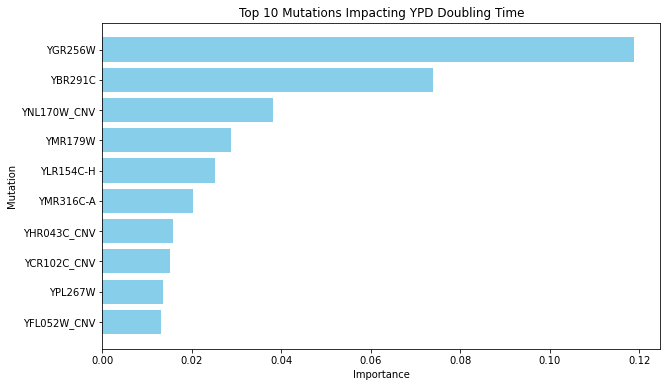

In [22]:
# Afficher et tracer les 10 caractéristiques les plus importantes
print("Affichage des 10 caractéristiques les plus importantes...")
feature_importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Importance": best_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Sélectionner les 10 caractéristiques les plus importantes
top_mutations = feature_importances_df.head(10)

# Afficher dans la console
print("\nMutations ayant le plus d'impact sur le YPD doubling time :")
print(top_mutations)

# Créer le graphique
plt.figure(figsize=(10, 6))
plt.barh(top_mutations["Feature"], top_mutations["Importance"], color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Mutation")
plt.title("Top 10 Mutations Impacting YPD Doubling Time")
plt.gca().invert_yaxis()
plt.show()

# SHAP importances

In [23]:
# SHAP analysis
print("Calculating SHAP values...")
explainer = shap.Explainer(best_model, X)
shap_values = explainer(X)
shap_mean_importance = np.abs(shap_values.values).mean(axis=0)

# Save SHAP feature importance
print("Saving SHAP feature importances...")
save_feature_importance(
    features=X.columns,
    importance_scores=shap_mean_importance,
    method="SHAP",
    model_name="GBM"
)

Calculating SHAP values...
Saving SHAP feature importances...
Feature importance saved to results/GBM_SHAP_importance.csv


Generating SHAP plots...


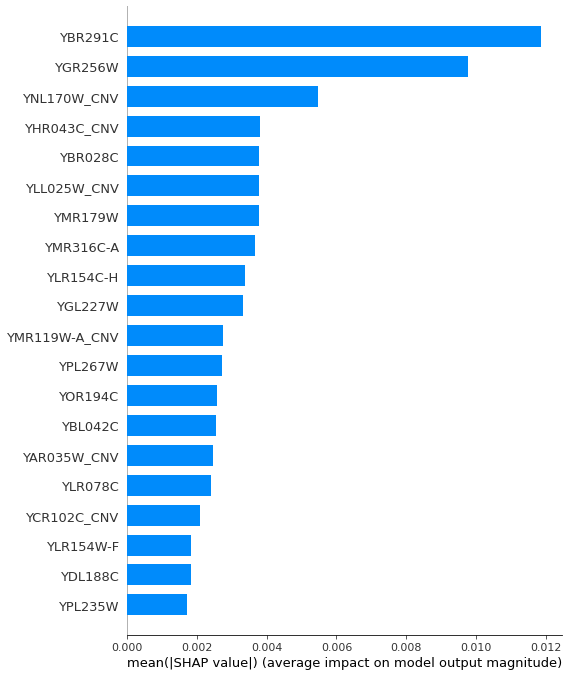

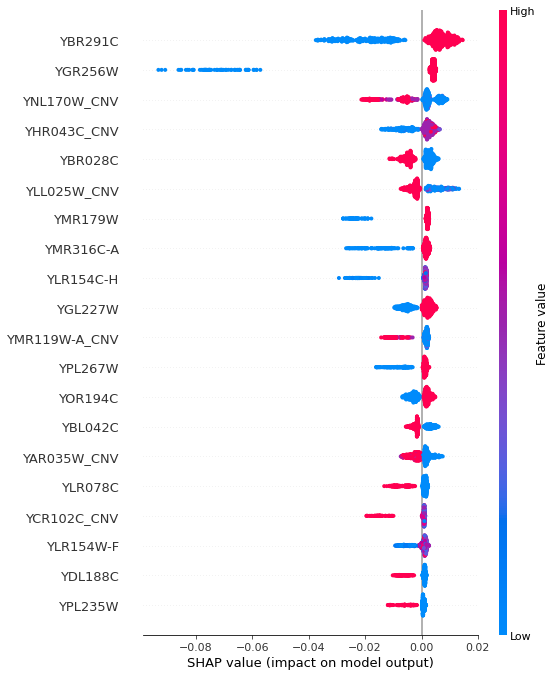

In [24]:
# Generate SHAP summary plots
print("Generating SHAP plots...")
shap.summary_plot(shap_values, X, plot_type="bar")
shap.summary_plot(shap_values, X)